# 한영 번역기 만들기
- 데이터: [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz) 
- 데이터 정제
    1. 데이터 병렬쌍 만든 후, 중복데이터를 제거한 cleaned_corpus 생성
    2. 한글 & 영어 정규식 추가
    3. 영문에 <start>, <end> 토큰 추가 후 split()으로 토큰화 수행
    4. 한글은 KoNLPy Mecab 클래스 사용
    5. cleaned corpus에서 토큰 길이 40 이하인 데이터 선별하여 eng_corpus, kor_corpus 각각 구축
- 데이터 토큰화
    - tokenized() 함수 사용. 단어의 수는 실험을 통해 값을 맞춤(최소 10000 이상)
    - 훈련 & 검증 데이터셋 나누지 않기
- 모델 설계
    - Attention 기반 Seq2seq 모델 설계
    - Dropout 모듈 추가 시 성능 향상
    - Embedding size & Hidden Size는 실험을 통해 적당한 값으로 맞춤
- 훈련하기
    - eval_step 사용 X
    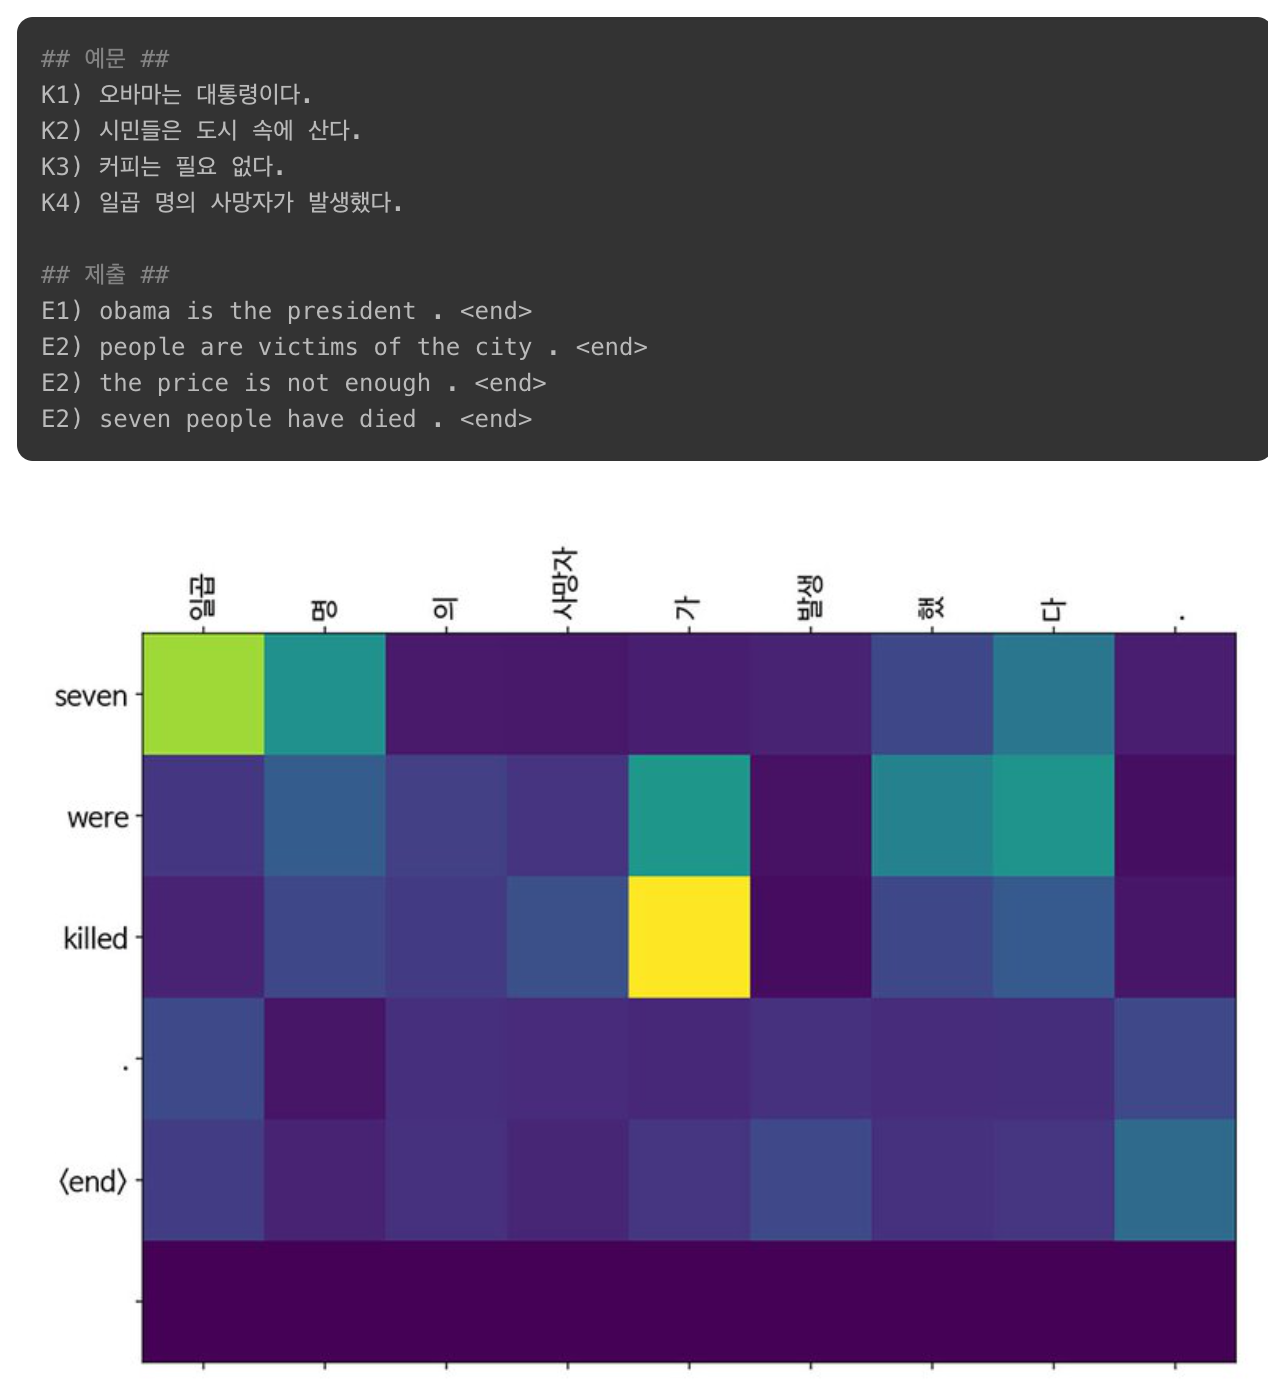

## Step 0. 필요 라이브러리 로드

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import requests
import random
import time
import re
import os
import io
from tqdm import tqdm

In [2]:
# matplotlib 한글 디스플레이 처리
import matplotlib as mpl

%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("한글 처리 완료!")

한글 처리 완료!


## Step 1. 데이터 다운로드 

In [6]:
path_to_zip = tf.keras.utils.get_file(
    "korean-english-park.train.tar.gz",
    origin = "https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz",
    extract = True
)
extracted_path = os.path.dirname(path_to_zip)
print(extracted_path)

/aiffel/.keras/datasets


In [7]:
ls ~/.keras/datasets

korean-english-park.train.en  korean-english-park.train.tar.gz
korean-english-park.train.ko


In [12]:
eng_fname = "/korean-english-park.train.en"
kor_fname =  "/korean-english-park.train.ko"

In [10]:
def load_data(extracted_path, fname):
    with open(extracted_path + fname, "r") as f:
        raw = f.read().splitlines()
    
    print(fname, "loaded")
    print("Data Size:", len(raw))
    print("Example: ")
    
    for sen in raw[0:100][::20]: print(">>", sen)
    
    return raw

In [13]:
eng_corpus = load_data(extracted_path, eng_fname)

/korean-english-park.train.en loaded
Data Size: 94123
Example: 
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [14]:
kor_corpus = load_data(extracted_path, kor_fname)

/korean-english-park.train.ko loaded
Data Size: 94123
Example: 
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


## Step 2. 데이터 정제 

In [20]:
# set 활용 중복 데이터 제거 cleaned_corpus 생성 
corpus = list(zip(kor_corpus, eng_corpus))
cleaned_corpus = list(set(corpus))
print("중복 제거 후 데이터 수: ", len(cleaned_corpus))

중복 제거 후 데이터 수:  78968


In [25]:
# 데이터 정제 함수 정의
def preprocess_sentence(sentence, kor = False, s_token = False, e_token = False):
    
    # 텍스트 정규화
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    if kor:
        sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    else:
        sentence = sentence.lower()
        sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    # 토큰 추가
    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'
    
    return sentence

In [26]:
# kor, eng 말뭉치 리스트 만들기
kor_corpus = []
eng_corpus = []

for pair in cleaned_corpus:
    kor = pair[0]
    eng = pair[1]
    
    kor_corpus.append(preprocess_sentence(kor, kor = True))
    eng_corpus.append(preprocess_sentence(eng, kor = False, s_token = True, e_token = True))

In [31]:
# 말뭉치 토큰으로 나누기
from konlpy.tag import Mecab

mecab = Mecab()

kor_corpus_clean = []
eng_corpus_clean = []

for kor, eng in zip(kor_corpus, eng_corpus):
    kor_token = mecab.morphs(kor)
    eng_token = eng.split()
    
    if (len(kor_token) <= 40) and (len(eng_token) <= 40):
        kor_corpus_clean.append(" ".join(kor_token))
        eng_corpus_clean.append(" ".join(eng_token))


In [32]:
print("토큰 40이하 데이터 수(KR): ", len(kor_corpus_clean))
print("토큰 40이하 데이터 수(EN): ", len(eng_corpus_clean))

토큰 40이하 데이터 수(KR):  61541
토큰 40이하 데이터 수(EN):  61541


## Step 3. 데이터 토큰화 

In [35]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    
    return tensor, tokenizer

In [36]:
kor_train, kor_tokenizer = tokenize(kor_corpus_clean)
eng_train, eng_tokenizer = tokenize(eng_corpus_clean)

## Step 4. 모델 설계 

In [38]:
# Attention 
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
        
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]        
        
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        attn = tf.nn.softmax(score, axis = 1)
        
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis = 1)
        
        return context_vec, attn

In [42]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences = True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [44]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                      return_sequences = True,
                                      return_state = True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis = -1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)
        
        return out, h_dec, attn

In [45]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 37967)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [52]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits = True, reduction = "none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [53]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)
        
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
            
    batch_loss = (loss / int(tgt.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [81]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_train.shape[-1], kor_train.shape[-1]))
    sentence = preprocess_sentence(sentence, kor = True)
    inputs = kor_tokenizer.texts_to_sequences([mecab.morphs(sentence)])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                          maxlen = kor_train.shape[-1],
                                                          padding = 'post')
    result = ''
    
    enc_out = encoder(inputs)
    
    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)
    
    for t in range(eng_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis = -1)[0]).numpy()
        
        result += eng_tokenizer.index_word[predicted_id] + ' '
        
        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention
        
        dec_input = tf.expand_dims([predicted_id], 0)
        
    return result, sentence, attention

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

## Step 5. 훈련하기 

In [55]:
from tqdm import tqdm

EPOCHS = 3

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx: idx + BATCH_SIZE],
                                eng_train[idx: idx + BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
        total_loss += batch_loss
        
        t.set_description_str("Epoch %2d" % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


Epoch  3: 100%|██████████| 962/962 [10:30<00:00,  1.53it/s, Loss 2.5893]


In [57]:
sample_data = ['오바마는 대통령이다.',
              '시민들은 도시 속에 산다.',
              '커피는 필요 없다.',
              '일곱 명의 사망자가 발생했다.']

In [74]:
for data in sample_data:
    translate(data, encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: obama s campaign said . <end> 
Input: 시민들은 도시 속에 산다 .
Predicted translation: they are also a day . <end> 
Input: 커피는 필요 없다 .
Predicted translation: the researchers can be a good thing ? <end> 
Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the death toll was killed in the death toll from the death toll from the death toll from the death toll from the death toll from the death toll from the death toll from the death toll from the death 


- 결과가 엄청 안좋다!!! 
- 심지어 마지막 문장은 같은 단어가 계속 반복됨...\<end> 토큰이 생성이 안된듯..

In [75]:
# 추가 2에폭 더 돌려보기...

ADD_EPOCHS = 2

for epoch in range(ADD_EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_train[idx: idx + BATCH_SIZE],
                                eng_train[idx: idx + BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
        total_loss += batch_loss
        
        t.set_description_str("Epoch %2d" % (epoch + 4))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


Epoch  5: 100%|██████████| 962/962 [10:31<00:00,  1.52it/s, Loss 2.1179]


In [76]:
for data in sample_data:
    translate(data, encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: obama s president obama is the president . <end> 
Input: 시민들은 도시 속에 산다 .
Predicted translation: they are in the city . <end> 
Input: 커피는 필요 없다 .
Predicted translation: the discs isn t always a good thing <end> 
Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: more than , people were killed . <end> 


Input: 사람들은 도시 속에 산다 .
Predicted translation: they are in the city . <end> 


/tmp/ipykernel_38/2223843881.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_38/2223843881.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


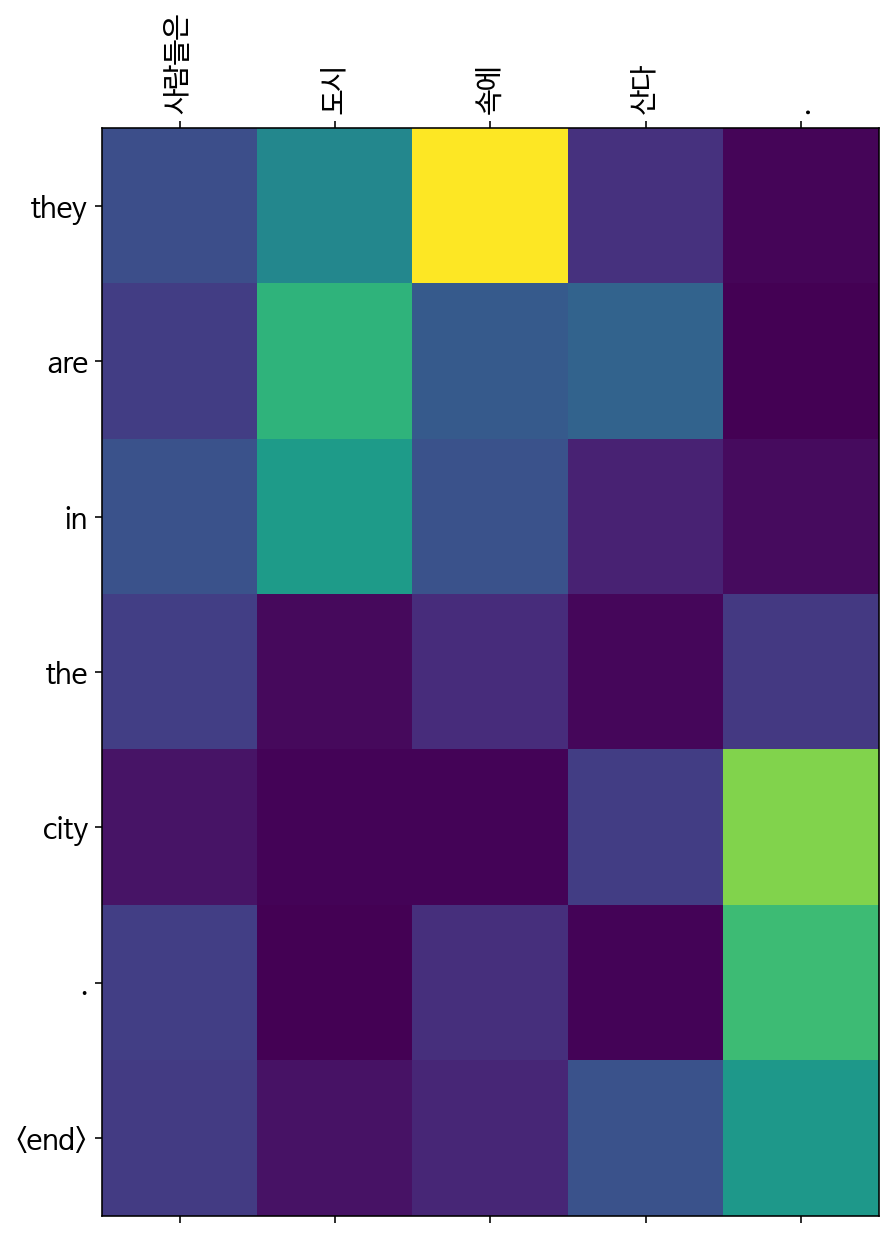

In [82]:
#  잘나온 결과물 출력
sent = '사람들은 도시 속에 산다.'
translate(sent, encoder, decoder)

- 해석 결과가 나름 나쁘지 않아서 attenton map 시각화 해봤는데... 결과가 형편없는 듯
- 가중치가 높은 부분의 단어들 사이의 연관성이 사람에게는 잘 안느껴지는 것 같다...

# 회고 

- LLM은 정말 시간과의 싸움같다...
- 3epoch -> 5epoch 정성적으로 성능 비교했을 때, 확연히 결과물이 좋아짐
- Loss값이 매 epoch별로 0.2 이상 떨어졌었고, 아직 과적합되지 않은 모델이어서 성능이 안나오는 듯 함
- 최소 10epoch 이상 돌려봤다면 결과가 더 나아졌을 것 같다.

**추가 실험을 한다면?**
- Vocab_size 변경하여 추가 모델 실험 필요
- Mecab 말고 다른 형태소 분석기를 사용한다면?
- Dropout 추가해서 모델 성능 확인할 것
- BLEU, ROUGE, METEOR 같은 정량적 평가지표로 각 스텝별 성능 평가를 해도 좋을 듯 함
    - 근데 아마 0점 나올듯?